In [1]:
from testproblems import generate_random_prob, random_problem_with_artifacts

In [2]:
from datastructures.operators import eqv_to_edges_tree, reformulate, invert_edges
from datastructures.graphutils import (default_tree, flat_graph_formulation, Node, COMP, VAR, sources, 
                                       draw_graph_graphical_props, copy_dicts)
from datastructures.rendering import render_incidence
import networkx as nx
from datastructures.tearing import min_max_scc2, min_arc_set_assign, min_arc_set, feedbacks

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [4]:
import seaborn as sns
import numpy as np

In [95]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Exploration

In [74]:
m = 10
n = 13
#seed 229 does not behave correctly
# (4,5,249,1.) is an interesting case
def func1(seed=229):
    sparsity = 1.#1.
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity)
    eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])
    print(np.mean([len(val) for val in eq_incidence.values()]))
    edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
    edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
    formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
    render_incidence(*formulation_scc, figsize=((4,4)), patchwidth=3);
    xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
    outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 
    formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
    render_incidence(*formulation_minassign, figsize=((4,4)));
    xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
    outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
    render_incidence(*formulation_minscc, figsize=((4,4)));
interact(func1, seed=(200,300)); # 20 looks good

interactive(children=(IntSlider(value=229, description='seed', max=300, min=200), Output()), _dom_classes=('wi…

In [46]:
from networkx.algorithms.bipartite import random_graph as bipartite_random_graph

In [66]:
sparsity = 0.5#1.
stats = {}
m = 20
n = 24
for sparsity,indepofn in [(3,True),(1.5,False)]:#[1, 2., 3, 4.]:
    stats[sparsity] = []
    for seed in range(1000):
        kwargs = random_problem_with_artifacts(m,n,seed,sparsity,independent_of_n=indepofn)
        p = (m+n)/(m*n)*sparsity
        #p = min(p, 1.0 - 1.0e-6) 
        G = bipartite_random_graph(m, n, p, seed)
        eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])
        stats[sparsity].append(np.mean([len(val) for val in eq_incidence.values()]))
        #mn = np.mean([len(G[node]) for node in range(m)])
        #stats[sparsity].append(mn)

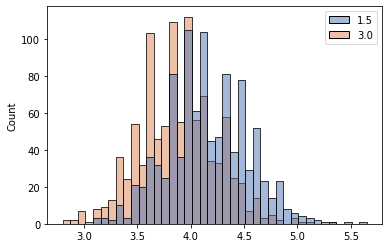

In [67]:
sns.histplot(data=stats, palette="deep", bins=40);

In [76]:
# For presentation slides, (m,n,seed) = (4,5,221,1.0)
m = 4#37,4
n = 5#45,5
seed = 220#221#269#257#23
runs = (
    (0.5, 'sparsity_half.png'),
    (1., 'sparsity_one.png'),
    (1.5, 'sparsity_one_and_half.png')
)
sparsity, figname = 1., ''
m,n,seed,sparsity = (4,5,221,1.0)
#m,n,seed,sparsity = 20,24,8,1.5
m,n,seed,sparsity = 10,13,227,1.

In [84]:
kwargs = random_problem_with_artifacts(m,n,seed,sparsity, independent_of_n=False)

In [85]:
eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])

In [86]:
np.mean([len(val) for val in eq_incidence.values()])

3.5

## Undirected formulation

In [83]:
#outset[3]=7

In [87]:
edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
tree_undir[2].update({val:1 for val in outset_adj.values()})

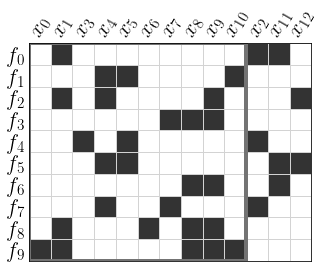

In [98]:
render_incidence(edges_undir, tree_undir, rotation=60, hideticks=True, save=False, fontsize=22, patchwidth=4);

In [17]:
# from scipy.sparse import csc_matrix
# from scipy.sparse.linalg import splu
# from datastructures.rendering import generate_incidence_matrix, plot_incidence_matrix
# from scipy.sparse.csgraph import reverse_cuthill_mckee

In [18]:
#A = generate_incidence_matrix(edges_dir[0], edges_dir[1], list(eqnidxs), [elt-m for elt in varidxs], diagonalgray=False)

In [19]:
# Asq = csc_matrix(A[:,list(outset_adj.values())], dtype=float)
# p = reverse_cuthill_mckee(Asq)

In [20]:
# Acm = (Asq.toarray()[p,:])[:,p]

In [21]:
# column_labels = ['$x_{}$'.format(var) for var in p]
# row_labels = ['$f_{}$'.format(fx) for fx in p]
# plot_incidence_matrix(Acm, column_labels, row_labels, **kwargs);

In [22]:
# column_labels = ['$x_{}$'.format(var) for var in range(10)]
# row_labels = ['$f_{}$'.format(fx) for fx in range(10)]
# plot_incidence_matrix(Asq.toarray(), column_labels, row_labels, **kwargs);

## Directed formulation
Based on initial formulation

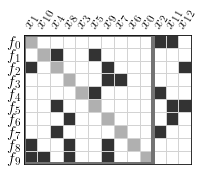

In [ ]:
render_incidence(edges_dir, tree_dir, figsize=((4,4)), figname="defense_scc_opt.png",, save=False, rotation=60, hideticks=True, patchwidth=4);

In [24]:
D = flat_graph_formulation(*edges_dir)

In [25]:
fvars, fcomps = feedbacks(D, [Node(idx,COMP) for idx in eqnidxs])

In [26]:
outset_f = {comp:var for comp,var in outset.items() if Node(comp,COMP) not in fcomps}

In [27]:
edges_fb,tree_fb,_ = eqv_to_edges_tree(eq_incidence, outset_f, n_eqs=m)
tree_fb

(OrderedDict([(0, 1), (1, 1), (2, 1), (3, 1)]), {}, {})

In [28]:
tree_fb[2].update({v.name: 1 for v in sorted(fvars, key=lambda x: x.name)})

In [29]:
tree_fb

(OrderedDict([(0, 1), (1, 1), (2, 1), (3, 1)]), {}, {2: 1, 3: 1})

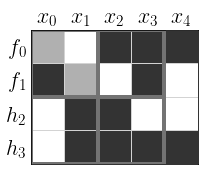

In [30]:
render_incidence(edges_fb, tree_fb, dispendcomp=True, figsize=((3,3)), figname="defense_feedback_equivalence_result.png", save=True, fontsize=22,rotation=0, hideticks=True, patchwidth=4);

## Condensation

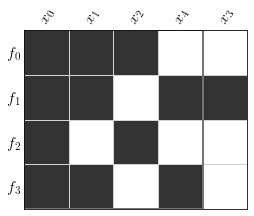

In [30]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
render_incidence(*formulation_scc, figsize=((4,4)), rotation=60, hideticks=True,);

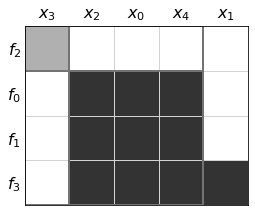

In [214]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc, figsize=((4,4)), rotation=0, hideticks=True,);

## DM fine

In [215]:
#draw_graph_graphical_props(G, prog='neato', figsize=(11,4))

In [216]:
Ein_no_source = {comp:tuple(var for var in allvars if var in outset.values()) for comp,allvars in eq_incidence.items()}
G = flat_graph_formulation(Ein_no_source,{},{},{VAR: 'x_{{{}}}', COMP: 'f_{{{}}}'})
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
edges_dir_m,tree_dir_m,_ = eqv_to_edges_tree(eq_incidence, m_out, n_eqs=m)

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

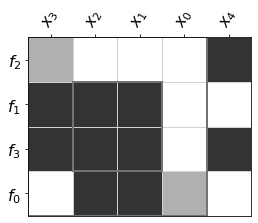

In [217]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1)
render_incidence(*formulation_scc_m, figsize=((4,4)));

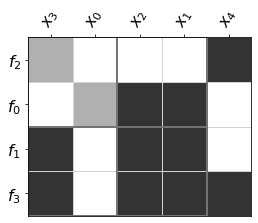

In [218]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc_m, figsize=((4,4)));

## MFA

In [31]:
cycles, elimset, model = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [32]:
elimset, {outset_adj[elt] for elt in elimset}

({0, 1}, {1, 2})

In [33]:
outset_mfa = {key:val for key,val in outset_adj.items() if key not in elimset}

### There is no IDF/MDF

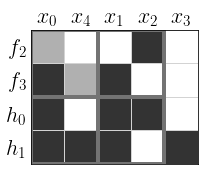

In [36]:
formulation_mfa = reformulate(edges_dir, tree_dir, outset_adj, outset_mfa, root_solver_name=1)
render_incidence(*formulation_mfa, figsize=((3,3)), figname="defense_fac_opt.png", save=True, dispendcomp=True, fontsize=22, rotation=0, hideticks=True, patchwidth=4);

## Tearing

In [223]:
fixed_inputs = set(varidxs)-set(outset.values())

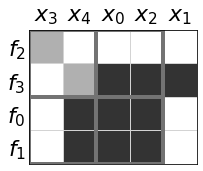

In [224]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_tear = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_tear = reformulate(edges_dir, tree_dir, outset_adj, outset_tear, 
                               not_outputs={elt-m for elt in fixed_inputs},
                               root_solver_name=1)
render_incidence(*formulation_tear, figsize=((3,3)), figname="defense_tear_opt.png", save=True, fontsize=22, rotation=0, hideticks=True, patchwidth=4);

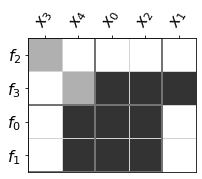

In [225]:
render_incidence(*formulation_tear, figsize=((3,3)));

## Tearing with input

In [89]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [90]:
edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 

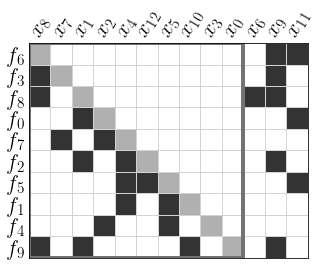

In [96]:
formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
render_incidence(*formulation_minassign, figsize=((5,5)), figname="defense_assign_opt.png", save=False, fontsize=22, rotation=60, hideticks=True, patchwidth=4);

## Min scc

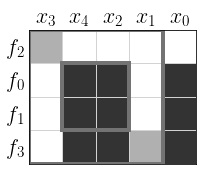

In [233]:
xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
render_incidence(*formulation_minscc, figsize=((3,3)), figname="defense_scc_opt.png", save=True, fontsize=22, rotation=0, hideticks=True, patchwidth=4);